In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from google.cloud import bigquery

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import ngrams, FreqDist

from unidecode import unidecode
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import networkx as nx



# nltk.download('punkt')
# nltk.download('stopwords')

## BQ client setup

In [2]:
def estimate_bigquery_query_cost(bq_client, query):
    
    job_config = bigquery.QueryJobConfig()
    job_config.dry_run = True
    job_config.use_query_cache = False
    query_job = bq_client.query(

        (
           query
        ),
        job_config=job_config,
    )
    
    cost_euros = (query_job.total_bytes_processed / 1024 ** 4) * 6

    print(f"{query_job.total_bytes_processed} bytes will be processed , cost ~{cost_euros}$")

In [3]:
bigquery_client= bigquery.Client(project="ingka-chscesda-solar-dev") # ingka-energy-solar-dev # ingka-energy-analytics-dev

## Varaibles for query

In [4]:
date_min = "2022-06-01"
date_max = "2022-06-10"

markets = tuple(['se', 'us',''])


# Get SQL string filter condition
product_string_queries = [
    'solar', 'sol', 'sun',
    'sunpower', 'svea', 
    'solstrale', 'SOLSTRÅLE', 
    'solpaneler', 'energy', 'electricity', 
]
string_exp = ' OR '.join([f'"{exp.lower()}" in UNNEST(internal_search_terms)' for exp in product_string_queries])
print(string_exp,'\n')

"solar" in UNNEST(internal_search_terms) OR "sol" in UNNEST(internal_search_terms) OR "sun" in UNNEST(internal_search_terms) OR "sunpower" in UNNEST(internal_search_terms) OR "svea" in UNNEST(internal_search_terms) OR "solstrale" in UNNEST(internal_search_terms) OR "solstråle" in UNNEST(internal_search_terms) OR "solpaneler" in UNNEST(internal_search_terms) OR "energy" in UNNEST(internal_search_terms) OR "electricity" in UNNEST(internal_search_terms) 



## Data mapping

#### Events, searches and pages 
(`ingka-web-analytics-prod.web_data_v2.hits_events_and_pages`): 
    - Landing on clean-energy (solar) tables, and session data
    - Searched string queries in the internal search bar
#### session data 
(`ingka-web-analytics-prod.web_data_v2.sessions`) - session data. Contains `icm_id`, `session_id` and `visitor_id`.

#### Customer data
- (`ikea-icm-prod.customer_master_golden_record_masked.v_cm_customer`) - Contains data on customer. *** waiting for access approval 
for info and access permissions *** 
- Alternatively - Use SCV **[single customer view](https://datacatalog.ingka.com/data/34/)** data for purchase history. Join `icm_id` key with hits events and pages. Start with [US data tables](https://datacatalog.ingka.com/schema/160/) until the Sweden data becomes available early August 2022.

Info on how to join session data to SCV (Jane Robinson):
```
Clickstream data is joined to our wider SCV dataset based on transaction ID or Sales Order Number (sono). 
We can then use the vistor ID assigned to these transactions to gather full browsing (and purchasing) history of this customer. 
If a customer has not purchased, we can use their ICM ID (when they are logged in) to gather full browsing history for that customer, 
conditional that the customer has made a transaction in store and they have an ICM ID. Currently, no clickstream data 
is surfaced in SCV KPI dashboards but is available to be used in the datasets
```

##### TODO:
- **Map google organic searches** (`ingka-do-seo-prod.integrated_search.gsc_est_revenue`) to IKEA user session activity. Attribution of organic searches, or grouping by user/session, is currently not possible
- Find **transactions data**, to see what visitors who reached CES goal have also bought (Use SCV?).



### Pages visited in sessions that included a landing in _any_ clean-energy page

In [16]:
# ### Page titles in sessions that included a landing in _any_ clean-energy page
# Visited pages
query_string = """
SELECT 
  pages.date_hit
  , pages.session_id
  , pages.page_titles
FROM (
  SELECT 
    date_hit
    -- , visitor_id
    , session_id
    , ARRAY_AGG(DISTINCT page_title) as page_titles
  FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
  WHERE 
      date_hit BETWEEN "{date_hit_min}" AND  "{date_hit_max}"
      AND website_market_short in {markets}
      AND event_category like '%page%'
      AND page_title is not NULL
  GROUP BY
      date_hit
      -- , visitor_id
      , session_id
) pages
INNER JOIN (
SELECT 
    DISTINCT session_id as session_id
FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
WHERE 
    date_hit BETWEEN "{date_hit_min}" AND  "{date_hit_max}"
    AND website_market_short in {markets}
    AND REGEXP_CONTAINS(page_url, ".+?clean-energy.+")
) cep
ON cep.session_id = pages.session_id
WHERE 
pages.date_hit BETWEEN "{date_hit_min}" AND  "{date_hit_max}"
""".format(
    date_hit_min=date_min, 
    date_hit_max=date_max, 
    markets=markets)
estimate_bigquery_query_cost(bigquery_client, query_string) 

148296025312 bytes will be processed , cost ~0.8092466958914883$


In [45]:
# Write to table
table_id="ingka-energy-analytics-dev.ces_da_playground.pages_temp"

job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=False,
    write_disposition = "WRITE_TRUNCATE"
)


bigquery_client.query(
    query_string, 
    job_config=job_config
).result()

In [55]:
# Results to pandas df
job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

## Clustering analysis

1. **Clean:** Parse page titles into keywords (or n-grams?), tokenize, stem, remove stopwords.
2. **Vectorize:** Count keywords co-occurences on session level, put pairs/ngrams into adjacency matrix.
3. Calculate **cos-similarity** between vectors.
4. **Cluster** (kmeans, dbscan, hdbscan)


In [5]:
# Read results from BQ

query_string = """
    SELECT * FROM ingka-energy-analytics-dev.ces_da_playground.pages_temp
"""

job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

# Read results from CSV
# PATH = '~/Downloads/bquxjob_3de0e649_182114894b2.csv'
# df = pd.read_csv(PATH)
df.head()

,date_hit,session_id,page_titles
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]"
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh..."
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA]
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem..."
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull..."


In [190]:
stop_en = set(stopwords.words('english'))
stop_se = set(stopwords.words('swedish'))
stop_se = set([unidecode(sw, "utf-8") for sw in stop_se])

stop_words = stop_se | stop_en
stop_words.update(['ikea', 'sok', "mer",
                   '-', '&', " ,", ",", "``", "/", 
                   "x", "xx", "search", "cm", 
                   "shop", "online",
                   "white", "black", "green", "brown", "gray", "dark", "light"
                   "vit", "svart", "gron", "brun", "gra", "mork", "ljus",
                   "sektion"
                  ])
# stop_words

stemmer = SnowballStemmer("swedish")

In [191]:

df['pt_std'] = df.page_titles.apply(
    # Convert to utf8, lower case and filter out numbers
    lambda x: [
        re.sub(r'.\d.|\d+|\`', '', unidecode(w.lower(), "utf-8")) for w in set(x) 
    ]
)
df['pt_tokens'] = df.pt_std.apply(
    # Tokenize
    lambda x: [
        nltk.tokenize.word_tokenize(w) for w in set(x)
    ]
)
df['doc'] = df.pt_tokens.apply(
    # Stem and remove stop words
    lambda x: " ".join([
        stemmer.stem(w) for title in x for w in title if w not in stop_words
    ])
)
df.head(10)

,date_hit,session_id,page_titles,pt_std,pt_tokens,doc
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]","[solceller - sok - ikea, el - sok - ikea]","[[el, -, sok, -, ikea], [solceller, -, sok, -,...",el solcell
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh...","[smarta och elektriska rullgardiner - ikea, sm...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin rullgardin morklagg...
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA],[smarta hem - ikea],"[[smarta, hem, -, ikea]]",smart hem
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem...","[ryet led ljuskalla lumen, opalvit - ikea, as...","[[smarta, hem, -, ikea], [kadrilj, rullgardin,...",smart hem kadrilj rullgardin tradlo batteridri...
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull...","[smarta och elektriska rullgardiner - ikea, sm...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin solcell paket pris ...
5,2022-07-17,68991779397134171971658085356,"[Smarta hem - IKEA, Solceller – paket och pris...","[vindriktning luftkvalitetsmatare - ikea, solc...","[[solceller, -, paket, och, priser, for, din, ...",solcell paket pris vill tak smart hem smart he...
6,2022-07-16,1019841633098230381658002370,[64791 - Sök - IKEA],[- sok - ikea],"[[-, sok, -, ikea]]",
7,2022-07-17,64536940361676008951658039039,[81892 - Sök - IKEA],[- sok - ikea],"[[-, sok, -, ikea]]",
8,2022-07-16,22714134062706553741657965453,"[Billy - Sök - IKEA, BILLY Bokhylla med glasdö...","[billy - sok - ikea, billy bokhylla med glasdo...","[[billy, -, sok, -, ikea], [billy, bokhylla, m...",billy billy bokhyll glasdorr metallikeffek
9,2022-07-17,33718153678820597471658085014,[456 55 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",


In [324]:
df['page_titles'][269]

array(['LAGKAPTEN / TILLSLAG Desk, light green/white, 551/8x235/8" - IKEA',
       'kitchen - Search - IKEA',
       'Home Furnishings & Home Goods - Shop Online - IKEA',
       'HAUGA Open wardrobe with 3 drawers, white, 271/2x783/8" - IKEA',
       'Storage Drawers - IKEA',
       'HEMNES 8-drawer dresser, dark gray stained, 63x373/8" - IKEA',
       'HAUGA Storage combination, white, 817/8x783/8" - IKEA',
       'HAUGA Storage combination, gray, 817/8x783/8" - IKEA',
       'Kids Wardrobes - IKEA', 'Bedroom Furniture - IKEA',
       'IDANÄS 6-drawer dresser, white, 633/4x373/8" - IKEA',
       'SMÅSTAD / UPPFÖRA 6-drawer chest, white/white, 235/8x243/4x531/2" - IKEA',
       "Kids' Dressers - Baby Chest of Drawers - IKEA",
       'Nursery Furniture - IKEA', 'IDANÄS series - IKEA',
       'HAUGA 6-drawer dresser, white, 543/8x331/8" - IKEA',
       'Furniture for Children - IKEA',
       'IDANÄS 6-drawer dresser, dark brown stained, 633/4x373/8" - IKEA'],
      dtype=object)

In [325]:
df['doc'][269]

"lagkapt tillslag desk light green/whit hom furnishing hom good haug open wardrob withdrawer idanasdraw dress stained kid wardrob storag drawer kitch smast uppforadraw chest white/whit haug storag combination hemnesdraw dress stained furnitur childr idanasdraw dress haugadraw dress bedroom furnitur haug storag combination kid ' dresser baby chest drawer idan seri nursery furnitur"

In [326]:
# Vectorizing 
# Using bag of words
vectorizer_cv = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 3))
X_cv = vectorizer_cv.fit_transform(df.doc).toarray()
vectorizer_cv.get_feature_names_out()

array(['acaci', 'acaci kullaberg', 'acaci kullaberg swivel', ..., 'zon',
       'zon vit', 'zon vit integrer'], dtype=object)

In [327]:
bow_mat = pd.concat([df.doc,pd.DataFrame(vectorizer_cv.fit_transform(df.doc).toarray(), columns = vectorizer_cv.get_feature_names_out())], axis=1)
bow_mat.head()

,doc,acaci,acaci kullaberg,acaci kullaberg swivel,accent,accent decorating,accent decorating frihet,accessori,accessori aurdal,accessori aurdal wardrob,...,ypper led floor,yta,yta antracit,yta antracit lamin,yuppienall,yuppienall hall,yuppienall hall mobiltelefon,zon,zon vit,zon vit integrer
0,el solcell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,smart elektrisk rullgardin rullgardin morklagg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,smart hem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,smart hem kadrilj rullgardin tradlo batteridri...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,smart elektrisk rullgardin solcell paket pris ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [328]:
# Calculate cosine similarity !!!

# coss_mat = np.dot(X_cv, X_cv.T) # / (np.linalg.norm(X_cv) * np.linalg.norm(X_cv))
X_cv_cs = pairwise.cosine_similarity(X_cv)
np.fill_diagonal(X_cv_cs, 0)
X_cv_cs

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03562765],
       [0.        , 0.        , 0.23245406, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.23245406, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03562765, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [329]:
# Cluster kmeans

# TODO find optimal K using elbow method

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_cv)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       4, 4, 4, 2, 6, 6, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6,
       6, 6, 6, 2, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 6, 6, 2, 2, 2, 6, 6,
       6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2,
       2, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5,
       5, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2,
       6, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [330]:
top_words_dict = {}
for i in range(kmeans.n_clusters):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(kmeans.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    print(words_count)
    top_words_str = " ".join([k for k in words_count][:3])
    top_words_dict[i] = top_words_str


df_clabels = pd.DataFrame(kmlabels, columns = ['cluster']).merge(
    pd.DataFrame(top_words_dict, index=['cluster_label']).T, left_on='cluster', right_index=True)

top_words_dict

{'energitjanst': 16, 'solpanel': 1}
{'solpanel': 16, 'solcell': 3}
{'kitch': 85, 'smart': 74, '``': 56, 'cabinet': 48, 'inspiration': 45, 'belysning': 38, 'storag': 36, 'vit': 35, 'lamp': 30, 'room': 30}
{'elavtal': 18, 'el': 18, 'sol': 18, 'vind': 18, 'solstral': 10}
{'solcell': 35}
{'solcell': 28, 'paket': 27, 'pris': 27, 'vill': 27, 'tak': 27, 'elavtal': 4, 'el': 4, 'sol': 4, 'vind': 4, 'smart': 1}
{'kitch': 212, 'inspiration': 44, 'gallery': 39, 'cabinet': 27, 'applianc': 25, 'upgr': 22, 'mod': 18, 'design': 14, 'ide': 13, 'system': 12}


{0: 'energitjanst solpanel',
 1: 'solpanel solcell',
 2: 'kitch smart ``',
 3: 'elavtal el sol',
 4: 'solcell',
 5: 'solcell paket pris',
 6: 'kitch inspiration gallery'}

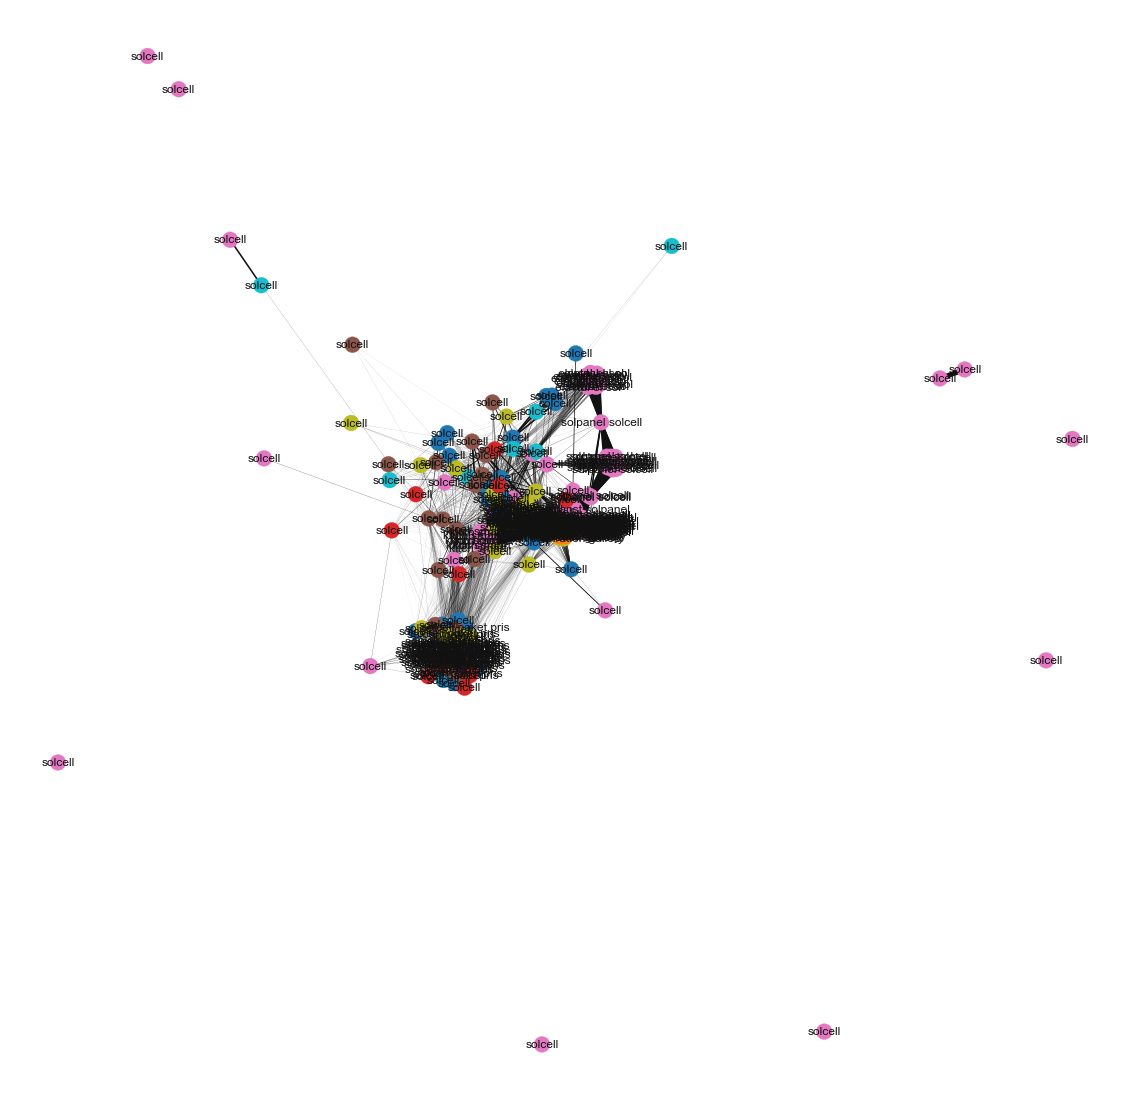

In [331]:
# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(X_cv_cs))

# Remove isolated nodes for easier drawing
# isolates = list(nx.isolates(G))
# G.remove_nodes_from(isolates)
# kmlabels = list(kmeans.labels_)
# [kmlabels.pop(i) for i in isolates]

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [5*w for w in nx.get_edge_attributes(G, 'weight').values()],
        node_color = df_clabels['cluster'],
        labels=df_clabels['cluster_label'],
        cmap=plt.get_cmap('tab10'), 
        ax=ax
       )

In [332]:
from sklearn.cluster import DBSCAN

cl_dbs = DBSCAN(
    eps=.25, 
    min_samples=2
).fit(X_cv)
cl_dbs.labels_

array([-1, -1, -1, -1, -1, -1,  0,  0, -1,  0, -1, -1, -1, -1,  1,  1, -1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3, -1, -1,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4, -1, -1, -1, -1, -1, -1,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, -1,  6,  6,  2,  2,
        2, -1,  7,  7, -1, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3, -1, -1, -1,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8, -1, -1, -1, -1, -1, -1, -1,  9,  9,  9, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       10, 10, 10, 10, 10, 10, 10, 10, 10, -1, -1, -1, -1, -1, 11, 11, 11,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, 11, 11, -1, -1, -1, -1, -1, -1, -1, -1, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       -1, -1, -1, -1, -1

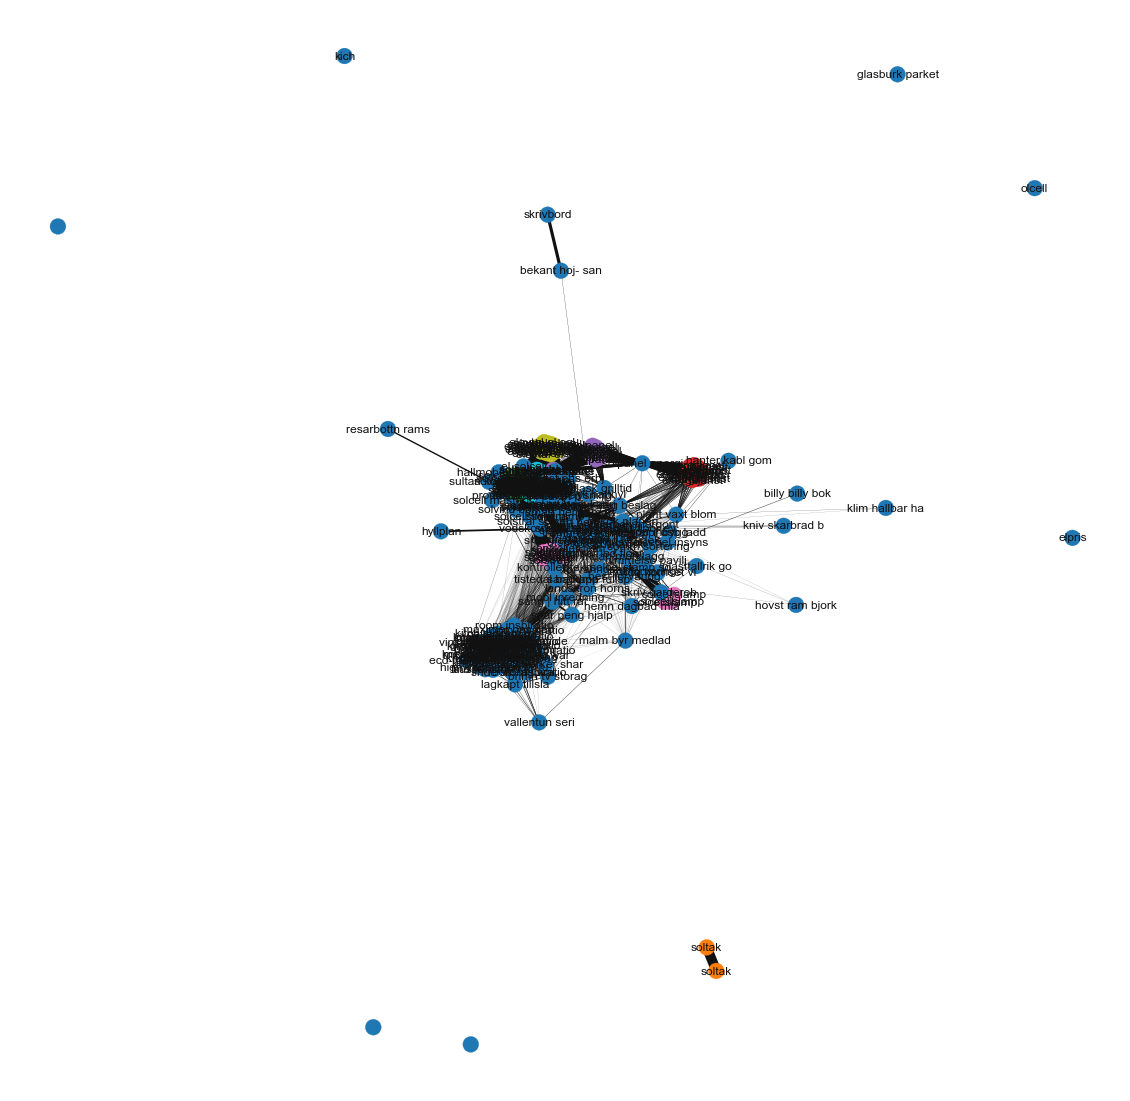

In [333]:

# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(
    X_cv_cs
))

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [10*w for w in nx.get_edge_attributes(G, 'weight').values()],
        node_color = cl_dbs.labels_,
        cmap=plt.get_cmap('tab10'),
        labels=df.doc.apply(lambda x: x[:15]), 
#         with_labels=True, 
        ax=ax
       )

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0
  0  0  0 -1  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  0  0  0 -1 -1 -1
 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 -1 -1
  3  3  3  3  3  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7  7  7  7  7  7  7  7
  7 -1 -1 -1 -1 -1  6  6  6  6  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6
  6 -1 -1 -1 -1 -1 -1 -1 -1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


/opt/homebrew/lib/python3.9/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

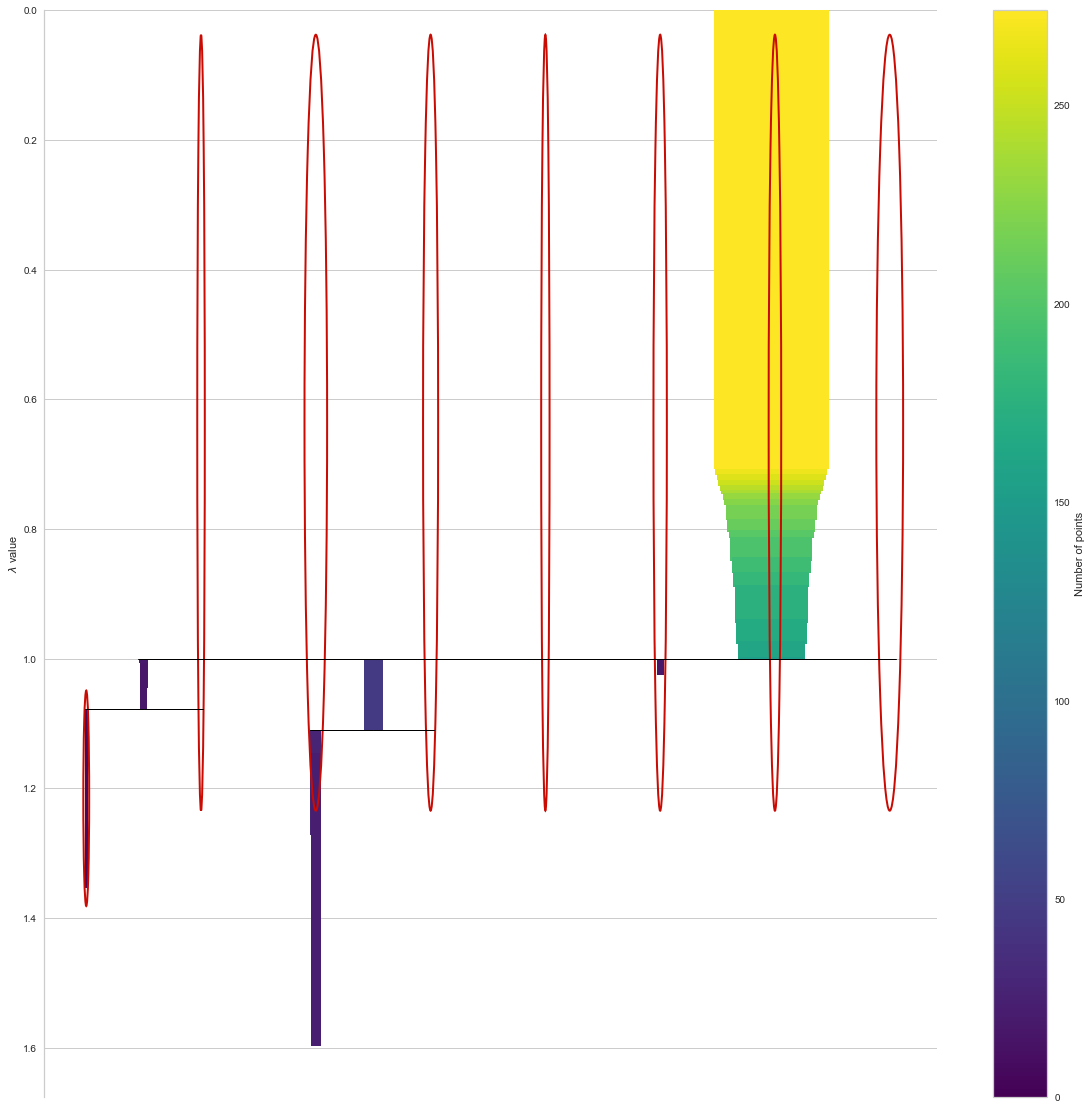

In [334]:
import hdbscan

# https://hdbscan.readthedocs.io/en/0.8.4/api.html

cl_hdbs = hdbscan.HDBSCAN(
    min_samples = 5, 
    min_cluster_size = 5,
    gen_min_span_tree = False,
)

cl_hdbs.fit(X_cv)
print(cl_hdbs.labels_)

fig, ax = plt.subplots(figsize=(20,20))
cl_hdbs.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


In [335]:
pd.DataFrame(cl_hdbs.labels_, columns = ['cluster']).merge(
    pd.DataFrame(top_words_dict, index=['cluster_label']).T, left_on='cluster', right_index=True)

,cluster,cluster_label
17,0,energitjanst solpanel
18,0,energitjanst solpanel
19,0,energitjanst solpanel
20,0,energitjanst solpanel
21,0,energitjanst solpanel
...,...,...
214,5,solcell paket pris
215,5,solcell paket pris
216,5,solcell paket pris
217,5,solcell paket pris


In [336]:
top_words_dict = {}
for i in range(0, len(set(cl_hdbs.labels_))-1):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(cl_hdbs.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str

top_words_dict[-1] = "unclustered"

df_clabels = pd.DataFrame(cl_hdbs.labels_, columns = ['cluster']).merge(
    pd.DataFrame(top_words_dict, index=['cluster_label']).T, left_on='cluster', right_index=True)

top_words_dict

{0: 'solcell',
 1: 'energitjanst',
 2: 'solpanel solcell',
 3: 'solstral',
 4: 'solcell paket pris vill tak',
 5: 'elavtal el sol vind',
 6: 'kitch gallery inspiration applianc upgr',
 7: 'gallery kitch inspiration',
 -1: 'unclustered'}

In [337]:
df_clabels[df_clabels['cluster'] != -1].cluster_label.unique()

array(['solcell', 'solcell paket pris vill tak', 'energitjanst',
       'solpanel solcell', 'solstral', 'gallery kitch inspiration',
       'kitch gallery inspiration applianc upgr', 'elavtal el sol vind'],
      dtype=object)

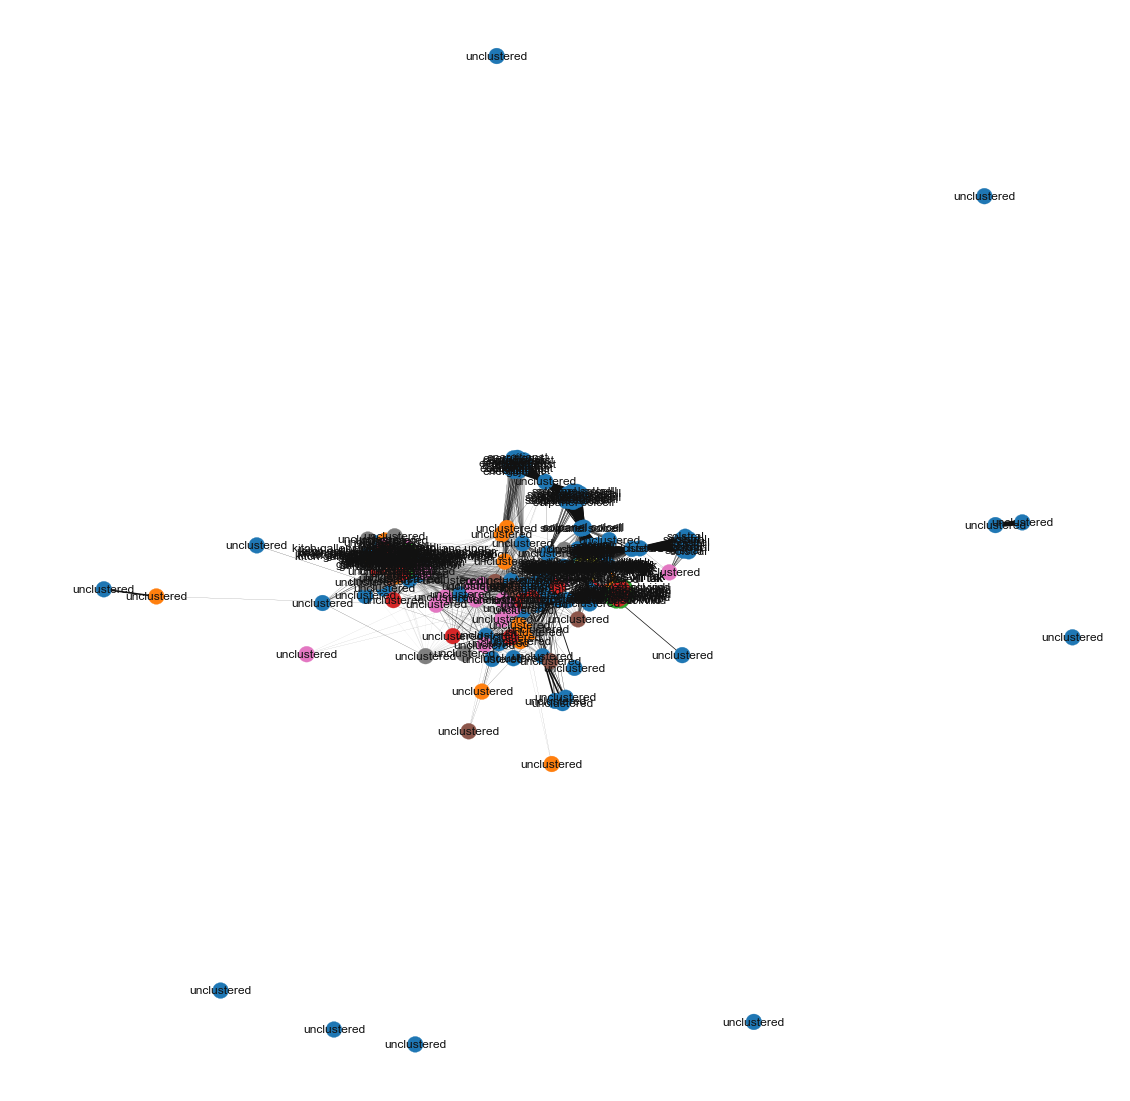

In [338]:
# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(X_cv_cs))

# Remove isolated nodes for easier drawing
# isolates = list(nx.isolates(G))
# G.remove_nodes_from(isolates)
# labels = list(cl_hdbs.labels_)
# [labels.pop(i) for i in isolates]

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = [5*w for w in nx.get_edge_attributes(G, 'weight').values()],
        node_color = df_clabels['cluster'],
        labels=df_clabels['cluster_label'],
        cmap=plt.get_cmap('tab10'),
        ax=ax
       )

In [339]:
df_clusters = df.merge(
    pd.concat([
    pd.DataFrame(kmeans.labels_, columns = ['kmeans']), 
    pd.DataFrame(cl_dbs.labels_, columns = ['dbscan']), 
    pd.DataFrame(cl_hdbs.labels_, columns = ['hdbscan'])], 
    axis=1),
    left_index=True, right_index=True
)
df_clusters.iloc[269]['doc']

"lagkapt tillslag desk light green/whit hom furnishing hom good haug open wardrob withdrawer idanasdraw dress stained kid wardrob storag drawer kitch smast uppforadraw chest white/whit haug storag combination hemnesdraw dress stained furnitur childr idanasdraw dress haugadraw dress bedroom furnitur haug storag combination kid ' dresser baby chest drawer idan seri nursery furnitur"

In [340]:
results = df[['doc']].merge(df_clabels, left_index=True, right_index=True)
results.groupby('cluster_label').cluster_label.count().sort_values(ascending=False)

cluster_label
unclustered                                140
solcell                                     32
solcell paket pris vill tak                 27
elavtal el sol vind                         18
solpanel solcell                            16
energitjanst                                15
solstral                                    10
gallery kitch inspiration                    9
kitch gallery inspiration applianc upgr      7
Name: cluster_label, dtype: int64

In [320]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X_cv)
(4, 2)

(4, 2)

<AxesSubplot:xlabel='tsne-x', ylabel='tsne-y'>

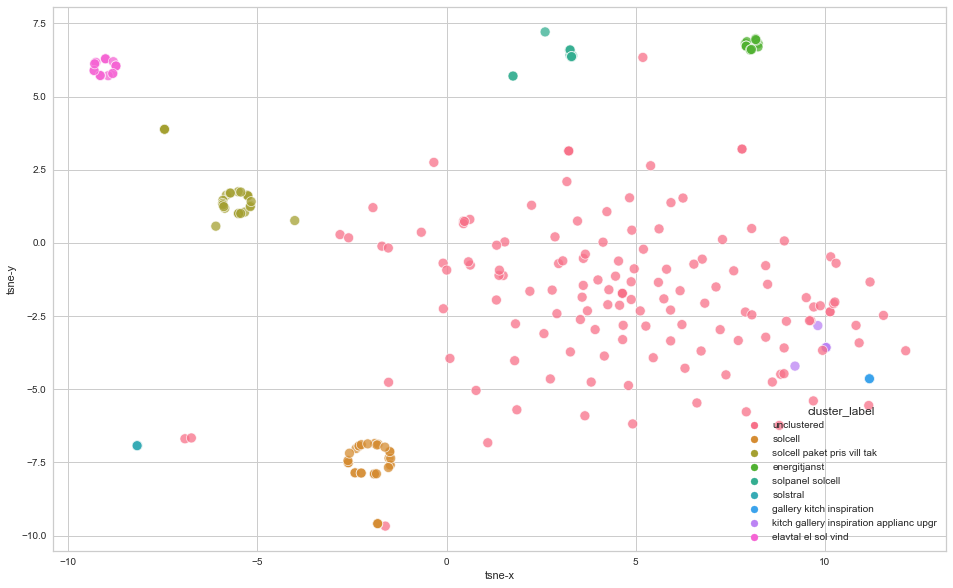

In [341]:

results['tsne-x'] = X_tsne[:,0]
results['tsne-y'] = X_tsne[:,1]

fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(
    ax=ax,
    data=results,
    x="tsne-x", y="tsne-y",
    hue="cluster_label",
    legend="full",
    s=100,
    alpha=0.75
)